In [1]:
# Referred to the following blog
# https://qiita.com/yoshizaki_kkgk/items/79f4056901dd9c059afb
# TODO: Classificalize / Functionalize

import time
import poloniex
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6

SAMPLING_RATE = 7200
SAMPLING_PERIOD =  360
WINDOW = int (( 3600 / SAMPLING_RATE ) * 24)

# poloniex APIの準備
polo = poloniex.Poloniex()

# 5分間隔（サンプリング間隔　SAMPLING_RATE(s) ）で SAMPLONG_PEIOD(D)分読み込む
#"period" (candlestick period in seconds; valid values are 300, 900,1800, 7200, 14400, and 86400)
chart_data = polo.returnChartData('BTC_ETH', period=SAMPLING_RATE, start=time.time()-polo.DAY*SAMPLING_PERIOD, end=time.time())

# pandasにデータの取り込み
df = pd.DataFrame(chart_data)
df['date'] = pd.to_datetime(df['date'].astype(int), unit='s')
df.head(10)

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,0.01231488,2017-02-16 16:00:00,0.01242989,0.01219,0.01241361,43495.45444944,534.53440778,0.01228943
1,0.0123,2017-02-16 18:00:00,0.01234,0.01211361,0.012321,29818.15881899,365.4117175,0.01225467
2,0.01236203,2017-02-16 20:00:00,0.0124,0.01226917,0.01230001,14671.72599505,181.09674851,0.01234324
3,0.01237207,2017-02-16 22:00:00,0.01245,0.01231,0.01235751,10969.26009229,135.82745848,0.01238255
4,0.01224748,2017-02-17 00:00:00,0.01241,0.012215,0.01238404,27739.4780397,341.19296007,0.0122999
5,0.01229,2017-02-17 02:00:00,0.0124,0.0122248,0.0122466,15441.12867257,190.70549056,0.01235048
6,0.01233826,2017-02-17 04:00:00,0.01233826,0.01225922,0.01229,6115.0620383,75.14713281,0.01228885
7,0.01232031,2017-02-17 06:00:00,0.01240761,0.01231009,0.01232601,8666.04919432,107.11221014,0.01235998
8,0.01227999,2017-02-17 08:00:00,0.01235,0.01226301,0.0123203,7566.92421263,93.03596034,0.01229508
9,0.01218412,2017-02-17 10:00:00,0.01231801,0.01218411,0.01227305,18992.00050028,232.43268554,0.01223845


/Users/takashi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1,center=False).mean()
  from ipykernel import kernelapp as app
/Users/takashi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/takashi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()


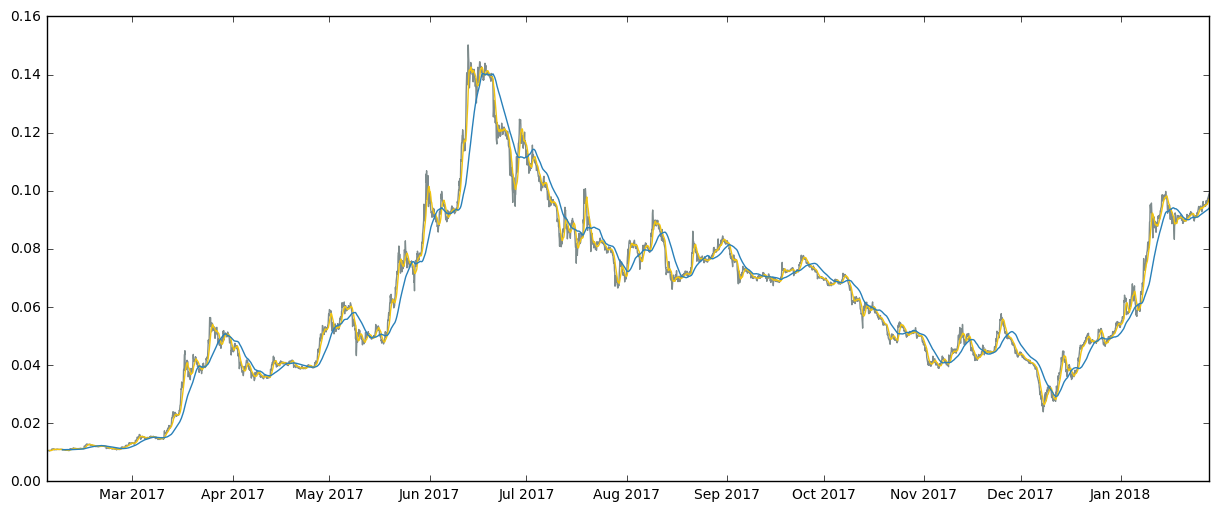

In [2]:
# 平均線: 窓幅 1 plot
data_d = pd.rolling_mean(df['close'], 1)
# 短期線：窓幅1日（5分×12×24）
data_s = pd.rolling_mean(df['close'], WINDOW) 
# 長期線：窓幅5日（5分×12×24×5）
data_l = pd.rolling_mean(df['close'], WINDOW * 5)

# 短期線と長期線もプロット
# plt.plot(df['close'], color='#7f8c8d')
plt.plot(df['date'], data_d, color='#7f8c8d')
plt.plot(df['date'], data_s,color='#f1c40f')    # 短期線
plt.plot(df['date'], data_l, color='#2980b9')  # 長期線
plt.show()

In [3]:
# 線形代数の演算でよく使うnumpyの読み込み
import numpy as np

# API経由では文字列（String型）として受け取るため、float型に変換しておく
# また、Chainerではfloat32を推奨しているため、こちらに合わせておく
data = df['close'].astype(np.float32)
date = df['date']

# データを入力変数xと出力変数tに切り分け
x, t = [], []
# 日付情報保持用の変数
x_d, t_d = [], []

N = len(data)
M = 30 # 入力変数の数：直近30サンプルを使用
for n in range(M, N):
    # 入力変数と出力変数の切り分け
    _x = data[n-M: n] # 入力変数
    _t = data[n] # 出力変数
    
    _x_date = date[n-M: n] # 入力変数
    _t_date = date[n] # 出力変数
    
    # 計算用のリスト(x, t)に追加していく
    x.append(_x)
    t.append(_t)
    
    x_d.append(_x_date)
    t_d.append(_t_date)
    
# numpyの形式に変換する（何かと便利なため）
x = np.array(x)
t = np.array(t).reshape(len(t), 1)  

x_date = np.array(x_d)
t_date = np.array(t_d).reshape(len(t_d), 1)  

# 70%を訓練用、30%を検証用
N_train = int(N * 0.7)
x_train, x_test = x[:N_train], x[N_train:]
t_train, t_test = t[:N_train], t[N_train:]

x_d_train, x_d_test = x_d[:N_train], x_d[N_train:]
t_d_train, t_d_test = t_d[:N_train], t_d[N_train:]

# PFNの開発者推奨の方法
train = list(zip(x_train, t_train))
test  = list(zip(x_test,  t_test))
t_train, t_test = t[:N_train], t[N_train:]
t_d_train, t_d_test = t_d[:N_train], t_d[N_train:]



In [4]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, datasets, optimizers
from chainer import report, training
from chainer.training import extensions

In [5]:
class LSTM(Chain):
    # モデルの構造を明記
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units) # LSTMの層を追加
            self.l2 = L.Linear(None, n_output)

    # LSTM内で保持する値をリセット
    def reset_state(self):
        self.l1.reset_state()

    # 損失関数の計算
    def __call__(self, x, t, train=True):
        y = self.predict(x, train)
        loss = F.mean_squared_error(y, t)
        if train:
            report({'loss': loss}, self)
        return loss

    # 順伝播の計算
    def predict(self, x, train=False):
        l1 = self.l1(x)
        h2 = self.l2(h1)
        return h2

In [6]:
class LSTMUpdater(training.StandardUpdater):
    def __init__(self, data_iter, optimizer, device=None):
        super(LSTMUpdater, self).__init__(data_iter, optimizer, device=None)
        self.device = device

    def update_core(self):
        data_iter = self.get_iterator("main")
        optimizer = self.get_optimizer("main")

        batch = data_iter.__next__()
        x_batch, y_batch = chainer.dataset.concat_examples(batch, self.device)

        # ↓ ここで reset_state() を実行できるようにしている
        optimizer.target.reset_state()

        # その他は時系列系の更新と同じ
        optimizer.target.cleargrads()
        loss = optimizer.target(x_batch, y_batch)
        loss.backward()
        # 時系列ではunchain_backward()によって計算効率が上がるそう
        loss.unchain_backward()
        optimizer.update()

In [7]:
class LSTM(Chain):
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units)
            self.l2 = L.Linear(None, n_output)

    def reset_state(self):
        self.l1.reset_state()

    def __call__(self, x, t, train=True):
        y = self.predict(x, train)
        loss = F.mean_squared_error(y, t)
        if train:
            report({'loss': loss}, self)
        return loss

    def predict(self, x, train=False):
        # ドロップアウトの追加（訓練時のみ使うようにする）
        if train:
            h1 = F.dropout(self.l1(x), ratio=0.05)
        else:
            h1 = self.l1(x)
        h2 = self.l2(h1)
        return h2

In [8]:
# chainer用のデータセットでメモリに乗る程度であれば、list(zip(...))を推奨
# ↑ PFNの開発者推奨の方法
train = list(zip(x_train, t_train))
test  = list(zip(x_test,  t_test))

# 再現性確保
np.random.seed(1)

# モデルの宣言
model = LSTM(30, 1)

# optimizerの定義
optimizer = optimizers.Adam()  # 最適化アルゴリズムはAdamを使用
optimizer.setup(model)

# iteratorの定義
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# updaterの定義
updater = LSTMUpdater(train_iter, optimizer)

# trainerの定義
epoch = 30
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')
# trainerの拡張機能
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport(trigger=(1,'epoch')))

# 1エポックごとに、trainデータに対するlossと、testデータに対するlossを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           0.000526298  0.00508595            0.283233      
2           4.52394e-05  0.00480096            0.593537      
3           4.10505e-05  0.00498691            0.901823      
4           3.56916e-05  0.00430362            1.20147       
5           3.16438e-05  0.00436335            1.49906       
6           2.77746e-05  0.00434119            1.79269       
7           2.75638e-05  0.00427871            2.08223       
8           2.29918e-05  0.00411327            2.37177       
9           2.11229e-05  0.0040174             2.6676        
10          1.77933e-05  0.00430618            2.9858        
11          1.6208e-05  0.00329649            3.38351       
12          1.48385e-05  0.00446779            3.72568       
13          1.61505e-05  0.00382043            4.12121       
14          1.35409e-05  0.00376857            4.45555       
15          1.2476e-05  0.00360536            4.79086       
16          1

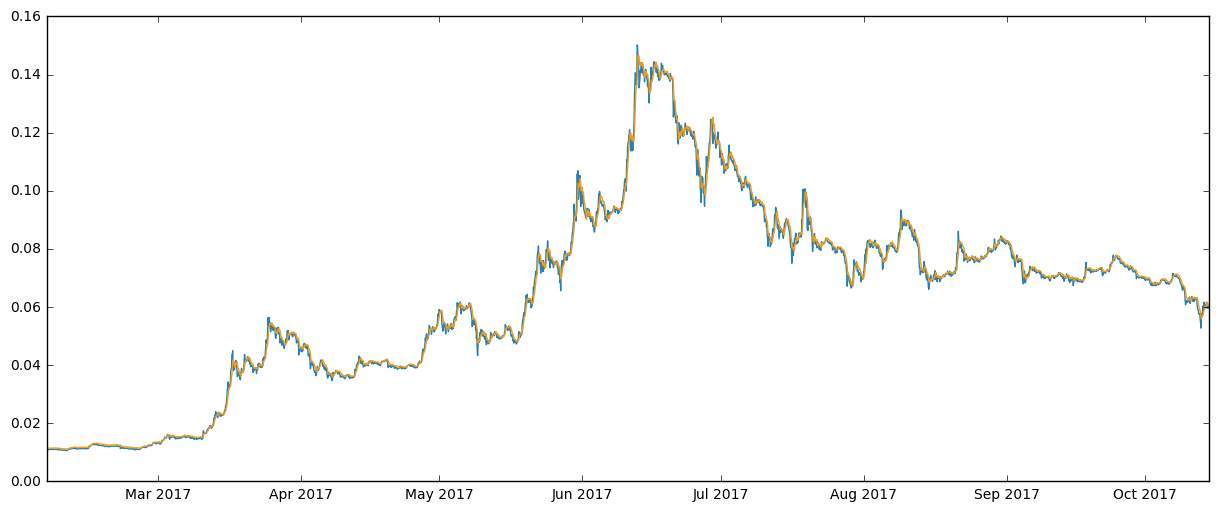

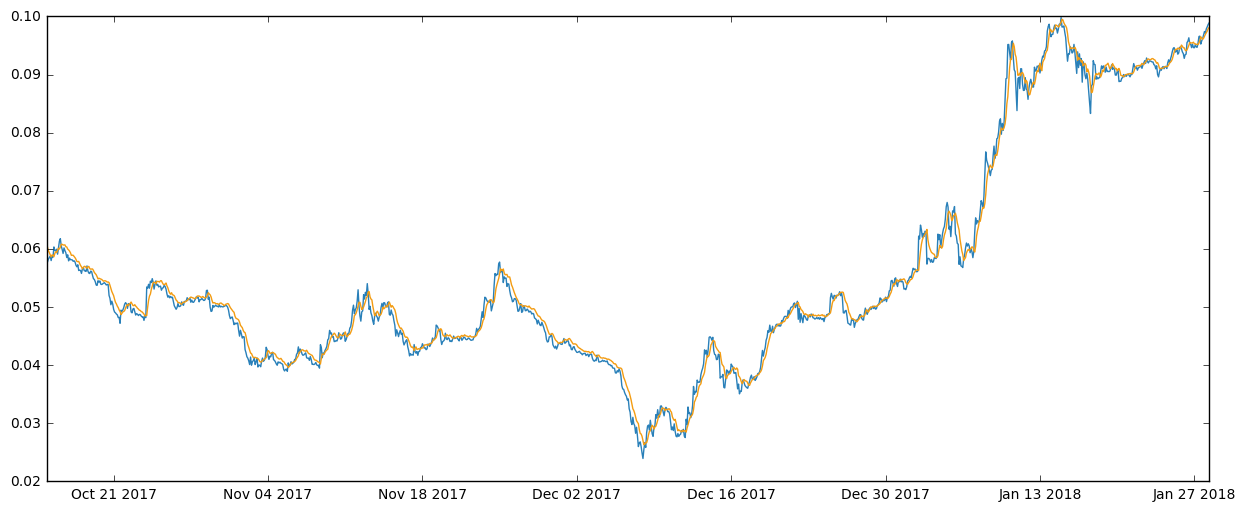

In [9]:
# 予測値の計算
model.reset_state()
y_train = model.predict(Variable(x_train)).data

# プロット
plt.plot(t_d_train, t_train, color='#2980b9') # 実測値は青色
plt.plot(t_d_train, y_train, color='#f39c12') # 予測値はオレンジ
plt.show()

# 予測値の計算
model.reset_state()
y_test = model.predict(Variable(x_test)).data

plt.plot(t_d_test, t_test, color='#2980b9')  # 実測値は青色
plt.plot(t_d_test, y_test, color='#f39c12')  # 予測値はオレンジ
plt.show()